#### 데이터셋 활용 꽃잎 너비 예측 모델  --- 선형회귀, 신경망 아님
- 데이터셋 : boston
- 구현 프레임워크 : Pytorch _ torchmetrics 모듈 사용해서 성능지표 확인

[1] 모듈 로딩 및 데이터 준비

In [1]:
# 모듈 로딩 
import torch                        # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn               # 인공신경망 관련 모듈
import torch.nn.functional as F     # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer     # 최적화 기법 관련 모듈

import pandas as pd                 # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split
from torchmetrics.regression import R2Score  # 성능 지표 관련 모듈 - 추가 설치

from torchinfo import summary       # 모델 정보 관련 모듈 - 추가 설치

In [2]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [3]:
# 데이터 로딩 : CSV ==> DataFrame
DATA_FILE = '../data/boston.csv'
irisDF = pd. read_csv(DATA_FILE)
irisDF.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [4]:
# 모델 설계
model = nn.Sequential(nn.Linear(13,100),
                         nn.ReLU(),
                         nn.Linear(100,50),
                         nn.ReLU(),
                         nn.Linear(50,1)) 

In [5]:
# 구조 확인
print(model)               
summary(model, input_size=(13,)) 

Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [100]                     1,400
├─ReLU: 1-2                              [100]                     --
├─Linear: 1-3                            [50]                      5,050
├─ReLU: 1-4                              [50]                      --
├─Linear: 1-5                            [1]                       51
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
Total mult-adds (M): 0.39
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [6]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}, {param}]\n')

[0.weight, Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  ...,  0.0769,  0.0137,  0.1013],
        [-0.1081, -0.0202, -0.0250,  ..., -0.1196, -0.0889,  0.0133],
        [ 0.1653,  0.1507, -0.2711,  ...,  0.2435, -0.0462,  0.1187],
        ...,
        [ 0.0008, -0.1158, -0.1698,  ..., -0.0050,  0.1828,  0.1527],
        [-0.1575, -0.1372, -0.1970,  ...,  0.1439,  0.0381,  0.1989],
        [ 0.0599, -0.0035,  0.0393,  ...,  0.0277,  0.2533, -0.1392]],
       requires_grad=True)]

[0.bias, Parameter containing:
tensor([-0.0512, -0.0167,  0.0914,  0.1048,  0.0628,  0.1094, -0.1190,  0.1167,
        -0.0879,  0.1743, -0.0814, -0.2362,  0.0198,  0.1443, -0.0109,  0.0036,
         0.0010,  0.1472,  0.0217, -0.2478, -0.1978,  0.0164, -0.0223,  0.2651,
        -0.0652,  0.2123, -0.2339, -0.2636, -0.0255, -0.1756, -0.0809,  0.0312,
        -0.2406,  0.1906, -0.1683,  0.2128,  0.0907, -0.0520, -0.2427,  0.0459,
        -0.1549,  0.2397, -0.2333, -0.0733, -0.1529, -0.1784, -0.1447, -0

[3] 최적화 인스턴스 준비

In [7]:
# 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim = optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현

-[4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행 하거나 또는 학습 전 진행

In [8]:
# 피쳐와 타겟 분리
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[['MEDV']]

print(featureDF.shape, targetDF.shape)

(506, 13) (506, 1)


In [9]:
# Train & test
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetDF,
                                                    test_size=0.20,
                                                    random_state=5)

# Train & val
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.15,
                                                    random_state=5)

print(f'[feature] Train{X_train.shape}, Test{X_test.shape}, Val{X_val.shape}')
print(f'[target] Train{y_train.shape}, Test{y_test.shape}, Val{y_val.shape}')

[feature] Train(343, 13), Test(102, 13), Val(61, 13)
[target] Train(343, 1), Test(102, 1), Val(61, 1)


[4-2] 학습진행 : 진행전    
- 학습횟수 결정 => 에포크 설정   
- 배치크기 결정     
- 배치개수 계산

In [10]:
EPOCH = 100                                  
BATCH_SIZE = 10
BATCH_CNT = X_train.shape[0]//BATCH_SIZE  

print(f'EPOCH: {EPOCH}, BATCH_SIZE: {BATCH_SIZE}, BATCH_CNT: {BATCH_CNT}')

EPOCH: 100, BATCH_SIZE: 10, BATCH_CNT: 34


In [11]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행

# 모델 검증 및 테스트 
def testing(testDF,targetDF, kind="Val"):

    # Tensor화
    testTS = torch.FloatTensor(testDF.values).to(DEVICE) # GPU에 있으면 GPU에 돌려라
    targetTS = torch.FloatTensor(targetDF.values).to(DEVICE)

    with torch.no_grad(): # 가중치 및 절편 업데이트 진행X

        # 1. 학습진행 - forward
        pre_y = model(testTS)

        # 2. 오차계산 - 손실함수
        loss = F.mse_loss(pre_y, targetTS) 

        # 3. 성능 평가- R2
        r2 = R2Score()(pre_y, targetTS)

        # 4. 학습결과 출력 및 저장
        # print(f'[ {kind} ] LOSS : {loss}, R2 : {r2}')

    return loss, r2

In [12]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    # [[],[]] <== [[train,val]
    loss_history= [[],[]]
    r2_history= [[],[]]

    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss, bs_r2 = 0, 0

        # 배치크기 만큼 학습진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE
            end = start + BATCH_SIZE
            print(start, end)

            # BS크기만큼만 데이터 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(DEVICE) # GPU에 있으면 GPU에 돌려라
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(DEVICE)

            # print(BSX_train.shape, BSX_train.device, BSX_train.dtype) 
            # print(BSy_train.shape, BSy_train.device, BSy_train.dtype) 


            # 1. 학습진행 - forward
            pre_y = model(BSX_train)
            # print(f'{pre_y.shape}')

            # 2. 오차계산 - 손실함수 >>>> 평균이요??? 한해포크 배치??
            bs_loss = F.mse_loss(pre_y, BSy_train)
            bs_loss += bs_loss
            bs_r2 += R2Score()(pre_y,BSy_train).item()

            # 3. 최적화 - 가중치, 절편 업데이트 backward
            adam_optim.zero_grad() 
            bs_loss.backward()
            adam_optim.step()

        # 4. 검증 - 모델이 제대로 만들어지는지 검사용
        val_loss, val_r2 = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        # 한 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss.item()/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        # 4. 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\n - Train LOSS : {loss_history[0][-1]}, R2:{r2_history[0][-1]}')
        print(f'- Valid Loss : {loss_history[1][-1]}, R2:{r2_history[1][-1]}')
        
    return loss_history, r2_history

In [13]:
# 모델 학습 진행
loss, r2 = training(X_train, y_train, X_val, y_val)

0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100
100 110
110 120
120 130
130 140
140 150
150 160
160 170
170 180
180 190
190 200
200 210
210 220
220 230
230 240
240 250
250 260
260 270
270 280
280 290
290 300
300 310
310 320
320 330
330 340
[0/100]
 - Train LOSS : 2.0250715367934284, R2:-463.6568576290327
- Valid Loss : 104.86051177978516, R2:-0.11486220359802246
0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100
100 110
110 120
120 130
130 140
140 150
150 160
160 170
170 180
180 190
190 200
200 210
210 220
220 230
230 240
240 250
250 260
260 270
270 280
280 290
290 300
300 310
310 320
320 330
330 340
[1/100]
 - Train LOSS : 7.9178565530216, R2:-0.5063707723337061
- Valid Loss : 77.22050476074219, R2:0.1790025234222412
0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100
100 110
110 120
120 130
130 140
140 150
150 160
160 170
170 180
180 190
190 200
200 210
210 220
220 230
230 240
240 250
250 260
260 270
270 280
280 290
290 300
300 310
310 320
320 330
330 340

In [14]:
loss

[[2.0250715367934284,
  7.9178565530216,
  3.9098425472483918,
  1.3730215184828813,
  1.3774851630715763,
  1.0312464096966911,
  1.065521240234375,
  1.2728448755600874,
  1.0594327590044808,
  0.8746597065645105,
  1.8654370027429916,
  0.8230841019574333,
  0.8369926003848805,
  1.200115764842314,
  1.0071091371424057,
  0.8044032489552218,
  0.8867191987879136,
  0.9424418281106388,
  0.8690374037798714,
  0.7188799801994773,
  0.8799011006074793,
  0.8713713814230526,
  0.8934196023380055,
  1.0923350839053882,
  0.9439993465647978,
  0.9497256559484145,
  0.8634495454676011,
  0.841867166406968,
  0.7850875854492188,
  0.7450765160953298,
  0.7313738430247587,
  0.8045119117288029,
  0.8358960432164809,
  0.7469013999490177,
  0.8592683567720301,
  0.8862803964053884,
  0.813729959375718,
  0.8771917679730583,
  0.754093843347886,
  0.7028587565702551,
  0.7048106474034926,
  0.7497080073637121,
  0.7419986724853516,
  0.8074732387767118,
  0.8113796570721794,
  0.79342696245978

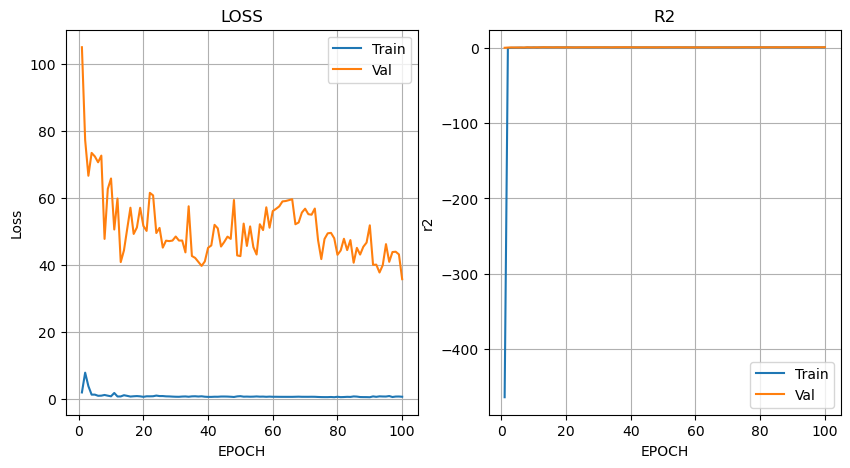

In [15]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=100 
fg, axes= plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(1,THRESHOLD+1), loss[0][:THRESHOLD], label='Train')
axes[0].plot(range(1,THRESHOLD+1), loss[1][:THRESHOLD], label='Val')
axes[0].set_title('LOSS')
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].grid()
axes[0].legend()


axes[1].plot(range(1,THRESHOLD+1), r2[0][:THRESHOLD], label='Train')
axes[1].plot(range(1,THRESHOLD+1), r2[1][:THRESHOLD], label='Val')
axes[1].set_title('R2')
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('r2')
axes[1].grid()
axes[1].legend()

plt.show()